# Machine Learning on a Public Dataset

Train and Evaluate the machine learning models

## Importing the Required Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
# local modules
from src.data_pipeline import data_pipeline
from src.models import UNet, DeepLabv4
from src.utils import train_and_evaluate

## Visualizing CossineAnnealing Learning Rate Scheduler

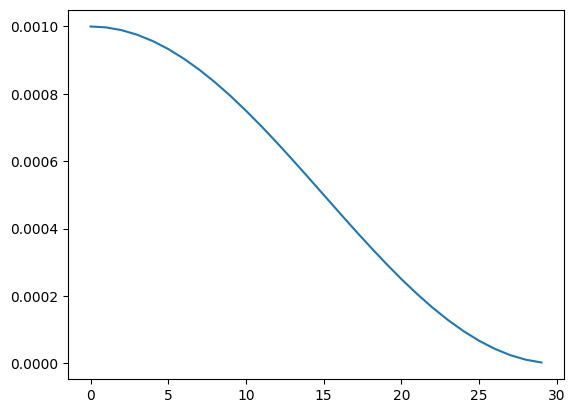

In [2]:
dummy_model = torch.nn.Sequential(torch.nn.Linear(32, 32))
dummy_opt = torch.optim.RAdam(dummy_model.parameters())
dummy_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dummy_opt, T_max=30)

lrs = []
for ep in range(30):
    lrs.append(dummy_scheduler.get_last_lr())
    dummy_opt.step()
    dummy_scheduler.step()

plt.plot(lrs)
plt.show()

## Train & Evaluate U-Net with no Augmentation for Baseline

In [3]:
model = UNet(3, 1)
train_and_evaluate(model, 'unet', augment=False, oversample=False)

--------- Epoch 1 ---------
Current learning rate: 0.00100


49it [00:20,  2.44it/s]


[Train]  Loss: 0.9857
[Test]  Loss: 0.9611 mIoU: 0.0809 Precision: 0.0819 Recall: 0.9351 F1: 0.1065
--------- Epoch 2 ---------
Current learning rate: 0.00100


49it [00:18,  2.65it/s]


[Train]  Loss: 0.9588
[Test]  Loss: 0.9394 mIoU: 0.1960 Precision: 0.2022 Recall: 0.9614 F1: 0.2418
--------- Epoch 3 ---------
Current learning rate: 0.00099


49it [00:18,  2.64it/s]


[Train]  Loss: 0.9451
[Test]  Loss: 0.9260 mIoU: 0.6039 Precision: 0.6700 Recall: 0.8961 F1: 0.6446
--------- Epoch 4 ---------
Current learning rate: 0.00098


49it [00:18,  2.61it/s]


[Train]  Loss: 0.9275
[Test]  Loss: 0.9053 mIoU: 0.5599 Precision: 0.5966 Recall: 0.9111 F1: 0.6014
--------- Epoch 5 ---------
Current learning rate: 0.00096


49it [00:18,  2.60it/s]


[Train]  Loss: 0.9054
[Test]  Loss: 0.8915 mIoU: 0.3185 Precision: 0.3532 Recall: 0.9413 F1: 0.3603
--------- Epoch 6 ---------
Current learning rate: 0.00093


49it [00:18,  2.63it/s]


[Train]  Loss: 0.8678
[Test]  Loss: 0.8703 mIoU: 0.6766 Precision: 0.8255 Recall: 0.8041 F1: 0.7085
--------- Epoch 7 ---------
Current learning rate: 0.00090


49it [00:18,  2.64it/s]


[Train]  Loss: 0.8021
[Test]  Loss: 0.7909 mIoU: 0.5924 Precision: 0.6754 Recall: 0.8942 F1: 0.6338
--------- Epoch 8 ---------
Current learning rate: 0.00087


49it [00:18,  2.64it/s]


[Train]  Loss: 0.6892
[Test]  Loss: 0.7197 mIoU: 0.7206 Precision: 0.8649 Recall: 0.8193 F1: 0.7516
--------- Epoch 9 ---------
Current learning rate: 0.00083


49it [00:18,  2.62it/s]


[Train]  Loss: 0.5232
[Test]  Loss: 0.6075 mIoU: 0.7582 Precision: 0.9053 Recall: 0.8320 F1: 0.7885
--------- Epoch 10 ---------
Current learning rate: 0.00079


49it [00:18,  2.63it/s]


[Train]  Loss: 0.3904
[Test]  Loss: 0.5252 mIoU: 0.7460 Precision: 0.8615 Recall: 0.8709 F1: 0.7814
--------- Epoch 11 ---------
Current learning rate: 0.00075


49it [00:18,  2.63it/s]


[Train]  Loss: 0.2976
[Test]  Loss: 0.4576 mIoU: 0.7491 Precision: 0.8614 Recall: 0.8726 F1: 0.7803
--------- Epoch 12 ---------
Current learning rate: 0.00070


49it [00:18,  2.65it/s]


[Train]  Loss: 0.2592
[Test]  Loss: 0.4142 mIoU: 0.7340 Precision: 0.8208 Recall: 0.8947 F1: 0.7692
--------- Epoch 13 ---------
Current learning rate: 0.00065


49it [00:18,  2.62it/s]


[Train]  Loss: 0.2164
[Test]  Loss: 0.4567 mIoU: 0.7492 Precision: 0.8519 Recall: 0.8668 F1: 0.7803
--------- Epoch 14 ---------
Current learning rate: 0.00060


49it [00:18,  2.61it/s]


[Train]  Loss: 0.1952
[Test]  Loss: 0.3612 mIoU: 0.7737 Precision: 0.8898 Recall: 0.8639 F1: 0.8060
--------- Epoch 15 ---------
Current learning rate: 0.00055


49it [00:18,  2.62it/s]


[Train]  Loss: 0.1610
[Test]  Loss: 0.3821 mIoU: 0.7686 Precision: 0.8761 Recall: 0.8622 F1: 0.8021
--------- Epoch 16 ---------
Current learning rate: 0.00050


49it [00:18,  2.63it/s]


[Train]  Loss: 0.1418
[Test]  Loss: 0.3426 mIoU: 0.7919 Precision: 0.9166 Recall: 0.8653 F1: 0.8233
--------- Epoch 17 ---------
Current learning rate: 0.00045


49it [00:18,  2.60it/s]


[Train]  Loss: 0.1332
[Test]  Loss: 0.3247 mIoU: 0.7903 Precision: 0.9013 Recall: 0.8786 F1: 0.8219
--------- Epoch 18 ---------
Current learning rate: 0.00040


49it [00:19,  2.58it/s]


[Train]  Loss: 0.1249
[Test]  Loss: 0.3309 mIoU: 0.8037 Precision: 0.9083 Recall: 0.8767 F1: 0.8353
--------- Epoch 19 ---------
Current learning rate: 0.00035


49it [00:18,  2.61it/s]


[Train]  Loss: 0.1207
[Test]  Loss: 0.3429 mIoU: 0.8140 Precision: 0.9331 Recall: 0.8703 F1: 0.8453
--------- Epoch 20 ---------
Current learning rate: 0.00030


49it [00:18,  2.61it/s]


[Train]  Loss: 0.1114
[Test]  Loss: 0.3139 mIoU: 0.7983 Precision: 0.9211 Recall: 0.8661 F1: 0.8295
--------- Epoch 21 ---------
Current learning rate: 0.00025


49it [00:18,  2.61it/s]


[Train]  Loss: 0.1092
[Test]  Loss: 0.3484 mIoU: 0.8088 Precision: 0.9277 Recall: 0.8635 F1: 0.8394
--------- Epoch 22 ---------
Current learning rate: 0.00021


49it [00:18,  2.62it/s]


[Train]  Loss: 0.1037
[Test]  Loss: 0.3216 mIoU: 0.7870 Precision: 0.8692 Recall: 0.8816 F1: 0.8198
--------- Epoch 23 ---------
Current learning rate: 0.00017


49it [00:18,  2.59it/s]


[Train]  Loss: 0.1034
[Test]  Loss: 0.3319 mIoU: 0.7845 Precision: 0.8820 Recall: 0.8833 F1: 0.8180
--------- Epoch 24 ---------
Current learning rate: 0.00013


49it [00:18,  2.59it/s]


[Train]  Loss: 0.1003
[Test]  Loss: 0.3271 mIoU: 0.7923 Precision: 0.8964 Recall: 0.8740 F1: 0.8248
--------- Epoch 25 ---------
Current learning rate: 0.00010


49it [00:18,  2.61it/s]


[Train]  Loss: 0.0981
[Test]  Loss: 0.3085 mIoU: 0.7877 Precision: 0.8849 Recall: 0.8801 F1: 0.8203
--------- Epoch 26 ---------
Current learning rate: 0.00007


49it [00:18,  2.60it/s]


[Train]  Loss: 0.0953
[Test]  Loss: 0.3065 mIoU: 0.7901 Precision: 0.8896 Recall: 0.8789 F1: 0.8228
--------- Epoch 27 ---------
Current learning rate: 0.00004


49it [00:18,  2.60it/s]


[Train]  Loss: 0.0946
[Test]  Loss: 0.3156 mIoU: 0.7910 Precision: 0.8937 Recall: 0.8754 F1: 0.8239
--------- Epoch 28 ---------
Current learning rate: 0.00002


49it [00:18,  2.62it/s]


[Train]  Loss: 0.0938
[Test]  Loss: 0.3112 mIoU: 0.7987 Precision: 0.9026 Recall: 0.8748 F1: 0.8311
--------- Epoch 29 ---------
Current learning rate: 0.00001


49it [00:18,  2.61it/s]


[Train]  Loss: 0.0929
[Test]  Loss: 0.3113 mIoU: 0.7950 Precision: 0.8963 Recall: 0.8773 F1: 0.8281
--------- Epoch 30 ---------
Current learning rate: 0.00000


49it [00:18,  2.59it/s]


[Train]  Loss: 0.0917
[Test]  Loss: 0.3142 mIoU: 0.7952 Precision: 0.9012 Recall: 0.8738 F1: 0.8277


## Visual validation of the Model Prediction

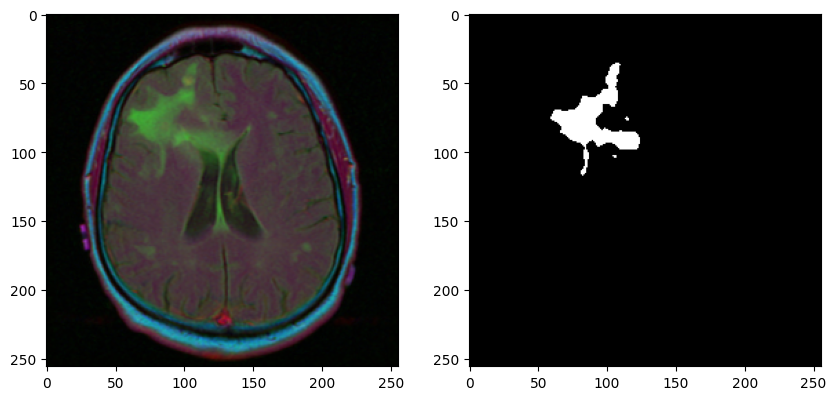

In [4]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/unet.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()

## Training and Evaluating Attention-Gated U-Net

In [5]:
model = UNet(3, 1, attention_gate=True)
train_and_evaluate(model, 'attention_gate_unet', augment=True, oversample=False)

--------- Epoch 1 ---------
Current learning rate: 0.00100


49it [00:21,  2.27it/s]


[Train]  Loss: 0.9875
[Test]  Loss: 0.9627 mIoU: 0.0503 Precision: 0.0503 Recall: 0.9790 F1: 0.0724
--------- Epoch 2 ---------
Current learning rate: 0.00100


49it [00:21,  2.32it/s]


[Train]  Loss: 0.9658
[Test]  Loss: 0.9496 mIoU: 0.1913 Precision: 0.2214 Recall: 0.9566 F1: 0.2247
--------- Epoch 3 ---------
Current learning rate: 0.00099


49it [00:21,  2.31it/s]


[Train]  Loss: 0.9547
[Test]  Loss: 0.9456 mIoU: 0.1032 Precision: 0.1033 Recall: 0.9855 F1: 0.1328
--------- Epoch 4 ---------
Current learning rate: 0.00098


49it [00:21,  2.28it/s]


[Train]  Loss: 0.9420
[Test]  Loss: 0.9340 mIoU: 0.1580 Precision: 0.1614 Recall: 0.9802 F1: 0.1931
--------- Epoch 5 ---------
Current learning rate: 0.00096


49it [00:21,  2.30it/s]


[Train]  Loss: 0.9262
[Test]  Loss: 0.9004 mIoU: 0.3459 Precision: 0.3706 Recall: 0.9337 F1: 0.3912
--------- Epoch 6 ---------
Current learning rate: 0.00093


49it [00:21,  2.31it/s]


[Train]  Loss: 0.8981
[Test]  Loss: 0.8935 mIoU: 0.2088 Precision: 0.2126 Recall: 0.9441 F1: 0.2502
--------- Epoch 7 ---------
Current learning rate: 0.00090


49it [00:21,  2.29it/s]


[Train]  Loss: 0.8645
[Test]  Loss: 0.8424 mIoU: 0.6709 Precision: 0.7863 Recall: 0.8613 F1: 0.7063
--------- Epoch 8 ---------
Current learning rate: 0.00087


49it [00:21,  2.26it/s]


[Train]  Loss: 0.8023
[Test]  Loss: 0.7726 mIoU: 0.5219 Precision: 0.5700 Recall: 0.9364 F1: 0.5618
--------- Epoch 9 ---------
Current learning rate: 0.00083


49it [00:21,  2.28it/s]


[Train]  Loss: 0.7071
[Test]  Loss: 0.6771 mIoU: 0.7445 Precision: 0.8754 Recall: 0.8518 F1: 0.7812
--------- Epoch 10 ---------
Current learning rate: 0.00079


49it [00:21,  2.27it/s]


[Train]  Loss: 0.5920
[Test]  Loss: 0.6167 mIoU: 0.7591 Precision: 0.9179 Recall: 0.8301 F1: 0.7886
--------- Epoch 11 ---------
Current learning rate: 0.00075


49it [00:21,  2.29it/s]


[Train]  Loss: 0.4905
[Test]  Loss: 0.5248 mIoU: 0.7843 Precision: 0.9113 Recall: 0.8580 F1: 0.8158
--------- Epoch 12 ---------
Current learning rate: 0.00070


49it [00:21,  2.29it/s]


[Train]  Loss: 0.4190
[Test]  Loss: 0.5057 mIoU: 0.6696 Precision: 0.7600 Recall: 0.8927 F1: 0.7062
--------- Epoch 13 ---------
Current learning rate: 0.00065


49it [00:21,  2.28it/s]


[Train]  Loss: 0.3557
[Test]  Loss: 0.4646 mIoU: 0.7531 Precision: 0.8856 Recall: 0.8477 F1: 0.7855
--------- Epoch 14 ---------
Current learning rate: 0.00060


49it [00:21,  2.27it/s]


[Train]  Loss: 0.3255
[Test]  Loss: 0.4083 mIoU: 0.7328 Precision: 0.8322 Recall: 0.8854 F1: 0.7695
--------- Epoch 15 ---------
Current learning rate: 0.00055


49it [00:21,  2.32it/s]


[Train]  Loss: 0.2684
[Test]  Loss: 0.3959 mIoU: 0.7996 Precision: 0.9199 Recall: 0.8705 F1: 0.8297
--------- Epoch 16 ---------
Current learning rate: 0.00050


49it [00:21,  2.31it/s]


[Train]  Loss: 0.2618
[Test]  Loss: 0.3682 mIoU: 0.7773 Precision: 0.8690 Recall: 0.8962 F1: 0.8096
--------- Epoch 17 ---------
Current learning rate: 0.00045


49it [00:21,  2.30it/s]


[Train]  Loss: 0.2547
[Test]  Loss: 0.3738 mIoU: 0.7781 Precision: 0.8754 Recall: 0.8918 F1: 0.8102
--------- Epoch 18 ---------
Current learning rate: 0.00040


49it [00:21,  2.29it/s]


[Train]  Loss: 0.2230
[Test]  Loss: 0.3423 mIoU: 0.7843 Precision: 0.8778 Recall: 0.8942 F1: 0.8155
--------- Epoch 19 ---------
Current learning rate: 0.00035


49it [00:21,  2.27it/s]


[Train]  Loss: 0.2167
[Test]  Loss: 0.3501 mIoU: 0.7882 Precision: 0.8839 Recall: 0.8942 F1: 0.8189
--------- Epoch 20 ---------
Current learning rate: 0.00030


49it [00:21,  2.31it/s]


[Train]  Loss: 0.1976
[Test]  Loss: 0.3537 mIoU: 0.7617 Precision: 0.8484 Recall: 0.8936 F1: 0.7928
--------- Epoch 21 ---------
Current learning rate: 0.00025


49it [00:21,  2.29it/s]


[Train]  Loss: 0.2003
[Test]  Loss: 0.3493 mIoU: 0.7857 Precision: 0.8778 Recall: 0.8973 F1: 0.8174
--------- Epoch 22 ---------
Current learning rate: 0.00021


49it [00:22,  2.20it/s]


[Train]  Loss: 0.1858
[Test]  Loss: 0.3211 mIoU: 0.8032 Precision: 0.8956 Recall: 0.8945 F1: 0.8323
--------- Epoch 23 ---------
Current learning rate: 0.00017


49it [00:22,  2.19it/s]


[Train]  Loss: 0.1873
[Test]  Loss: 0.3413 mIoU: 0.8142 Precision: 0.9360 Recall: 0.8679 F1: 0.8417
--------- Epoch 24 ---------
Current learning rate: 0.00013


49it [00:22,  2.18it/s]


[Train]  Loss: 0.1753
[Test]  Loss: 0.3369 mIoU: 0.8167 Precision: 0.9510 Recall: 0.8534 F1: 0.8427
--------- Epoch 25 ---------
Current learning rate: 0.00010


49it [00:22,  2.21it/s]


[Train]  Loss: 0.1687
[Test]  Loss: 0.2775 mIoU: 0.8167 Precision: 0.9215 Recall: 0.8857 F1: 0.8471
--------- Epoch 26 ---------
Current learning rate: 0.00007


49it [00:21,  2.25it/s]


[Train]  Loss: 0.1619
[Test]  Loss: 0.2736 mIoU: 0.8071 Precision: 0.8880 Recall: 0.9017 F1: 0.8398
--------- Epoch 27 ---------
Current learning rate: 0.00004


49it [00:21,  2.26it/s]


[Train]  Loss: 0.1562
[Test]  Loss: 0.2506 mIoU: 0.8256 Precision: 0.9112 Recall: 0.9028 F1: 0.8561
--------- Epoch 28 ---------
Current learning rate: 0.00002


49it [00:21,  2.26it/s]


[Train]  Loss: 0.1537
[Test]  Loss: 0.2530 mIoU: 0.8245 Precision: 0.9088 Recall: 0.9018 F1: 0.8551
--------- Epoch 29 ---------
Current learning rate: 0.00001


49it [00:22,  2.17it/s]


[Train]  Loss: 0.1537
[Test]  Loss: 0.2617 mIoU: 0.8228 Precision: 0.9085 Recall: 0.9013 F1: 0.8533
--------- Epoch 30 ---------
Current learning rate: 0.00000


49it [00:22,  2.20it/s]


[Train]  Loss: 0.1543
[Test]  Loss: 0.2598 mIoU: 0.8224 Precision: 0.9077 Recall: 0.9015 F1: 0.8528


## Visual validation of the Model Prediction

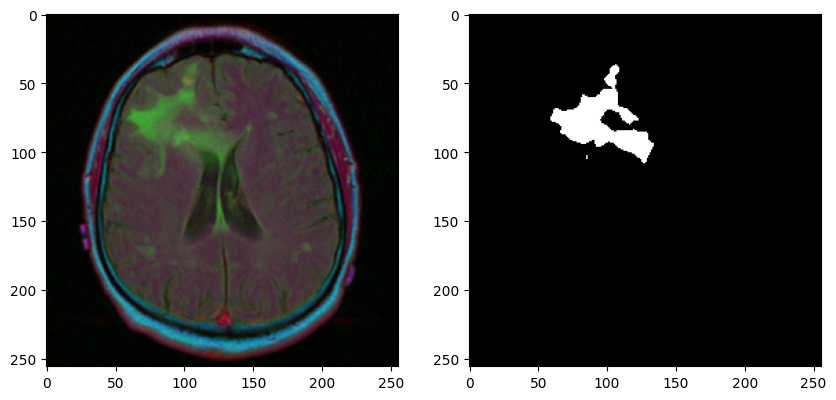

In [6]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/attention_gate_unet.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()

## Training and Evaluating U-Net with Deformable Convolution

In [7]:
model = UNet(3, 1, attention_gate=False, dcn=True)
train_and_evaluate(model, 'deformable_unet', augment=True, oversample=False)

--------- Epoch 1 ---------
Current learning rate: 0.00100


49it [00:44,  1.10it/s]


[Train]  Loss: 0.9857
[Test]  Loss: 0.9661 mIoU: 0.0489 Precision: 0.0490 Recall: 0.9546 F1: 0.0684
--------- Epoch 2 ---------
Current learning rate: 0.00100


49it [00:44,  1.10it/s]


[Train]  Loss: 0.9708
[Test]  Loss: 0.9555 mIoU: 0.0971 Precision: 0.0976 Recall: 0.9778 F1: 0.1275
--------- Epoch 3 ---------
Current learning rate: 0.00099


49it [00:44,  1.09it/s]


[Train]  Loss: 0.9645
[Test]  Loss: 0.9459 mIoU: 0.1926 Precision: 0.1990 Recall: 0.9689 F1: 0.2322
--------- Epoch 4 ---------
Current learning rate: 0.00098


49it [00:44,  1.10it/s]


[Train]  Loss: 0.9588
[Test]  Loss: 0.9397 mIoU: 0.3529 Precision: 0.3886 Recall: 0.9220 F1: 0.3945
--------- Epoch 5 ---------
Current learning rate: 0.00096


49it [00:44,  1.09it/s]


[Train]  Loss: 0.9491
[Test]  Loss: 0.9274 mIoU: 0.5749 Precision: 0.6758 Recall: 0.8633 F1: 0.6137
--------- Epoch 6 ---------
Current learning rate: 0.00093


49it [00:45,  1.08it/s]


[Train]  Loss: 0.9365
[Test]  Loss: 0.9427 mIoU: 0.4760 Precision: 0.6123 Recall: 0.7723 F1: 0.5055
--------- Epoch 7 ---------
Current learning rate: 0.00090


49it [00:45,  1.07it/s]


[Train]  Loss: 0.9171
[Test]  Loss: 0.9126 mIoU: 0.2288 Precision: 0.2453 Recall: 0.9626 F1: 0.2672
--------- Epoch 8 ---------
Current learning rate: 0.00087


49it [00:44,  1.10it/s]


[Train]  Loss: 0.8891
[Test]  Loss: 0.8670 mIoU: 0.4270 Precision: 0.4687 Recall: 0.9309 F1: 0.4684
--------- Epoch 9 ---------
Current learning rate: 0.00083


49it [00:44,  1.10it/s]


[Train]  Loss: 0.8474
[Test]  Loss: 0.8454 mIoU: 0.2749 Precision: 0.2989 Recall: 0.9268 F1: 0.3156
--------- Epoch 10 ---------
Current learning rate: 0.00079


49it [00:44,  1.11it/s]


[Train]  Loss: 0.7723
[Test]  Loss: 0.7564 mIoU: 0.6913 Precision: 0.8179 Recall: 0.8578 F1: 0.7244
--------- Epoch 11 ---------
Current learning rate: 0.00075


49it [00:44,  1.10it/s]


[Train]  Loss: 0.7178
[Test]  Loss: 0.7437 mIoU: 0.7389 Precision: 0.9256 Recall: 0.7933 F1: 0.7725
--------- Epoch 12 ---------
Current learning rate: 0.00070


49it [00:44,  1.11it/s]


[Train]  Loss: 0.6181
[Test]  Loss: 0.6508 mIoU: 0.7344 Precision: 0.8964 Recall: 0.8235 F1: 0.7623
--------- Epoch 13 ---------
Current learning rate: 0.00065


49it [00:44,  1.11it/s]


[Train]  Loss: 0.5246
[Test]  Loss: 0.6542 mIoU: 0.6826 Precision: 0.8920 Recall: 0.7790 F1: 0.7085
--------- Epoch 14 ---------
Current learning rate: 0.00060


49it [00:44,  1.11it/s]


[Train]  Loss: 0.4587
[Test]  Loss: 0.5650 mIoU: 0.6663 Precision: 0.7914 Recall: 0.8516 F1: 0.7005
--------- Epoch 15 ---------
Current learning rate: 0.00055


49it [00:44,  1.11it/s]


[Train]  Loss: 0.4023
[Test]  Loss: 0.4948 mIoU: 0.7194 Precision: 0.8525 Recall: 0.8524 F1: 0.7499
--------- Epoch 16 ---------
Current learning rate: 0.00050


49it [00:43,  1.12it/s]


[Train]  Loss: 0.3732
[Test]  Loss: 0.5040 mIoU: 0.7346 Precision: 0.8821 Recall: 0.8377 F1: 0.7647
--------- Epoch 17 ---------
Current learning rate: 0.00045


49it [00:43,  1.12it/s]


[Train]  Loss: 0.3527
[Test]  Loss: 0.4574 mIoU: 0.7528 Precision: 0.8837 Recall: 0.8555 F1: 0.7830
--------- Epoch 18 ---------
Current learning rate: 0.00040


49it [00:43,  1.12it/s]


[Train]  Loss: 0.3174
[Test]  Loss: 0.4432 mIoU: 0.7760 Precision: 0.9083 Recall: 0.8532 F1: 0.8047
--------- Epoch 19 ---------
Current learning rate: 0.00035


49it [00:43,  1.11it/s]


[Train]  Loss: 0.2905
[Test]  Loss: 0.4269 mIoU: 0.7759 Precision: 0.9078 Recall: 0.8581 F1: 0.8051
--------- Epoch 20 ---------
Current learning rate: 0.00030


49it [00:44,  1.10it/s]


[Train]  Loss: 0.2772
[Test]  Loss: 0.4249 mIoU: 0.7715 Precision: 0.8780 Recall: 0.8848 F1: 0.8035
--------- Epoch 21 ---------
Current learning rate: 0.00025


49it [00:44,  1.10it/s]


[Train]  Loss: 0.2663
[Test]  Loss: 0.3970 mIoU: 0.7914 Precision: 0.9230 Recall: 0.8604 F1: 0.8198
--------- Epoch 22 ---------
Current learning rate: 0.00021


49it [00:44,  1.11it/s]


[Train]  Loss: 0.2502
[Test]  Loss: 0.3818 mIoU: 0.8024 Precision: 0.9323 Recall: 0.8603 F1: 0.8323
--------- Epoch 23 ---------
Current learning rate: 0.00017


49it [00:44,  1.09it/s]


[Train]  Loss: 0.2351
[Test]  Loss: 0.3863 mIoU: 0.7924 Precision: 0.9070 Recall: 0.8760 F1: 0.8227
--------- Epoch 24 ---------
Current learning rate: 0.00013


49it [00:45,  1.08it/s]


[Train]  Loss: 0.2302
[Test]  Loss: 0.4105 mIoU: 0.7613 Precision: 0.8682 Recall: 0.8806 F1: 0.7921
--------- Epoch 25 ---------
Current learning rate: 0.00010


49it [00:45,  1.08it/s]


[Train]  Loss: 0.2309
[Test]  Loss: 0.3689 mIoU: 0.7979 Precision: 0.9180 Recall: 0.8704 F1: 0.8283
--------- Epoch 26 ---------
Current learning rate: 0.00007


49it [00:44,  1.09it/s]


[Train]  Loss: 0.2247
[Test]  Loss: 0.3689 mIoU: 0.7989 Precision: 0.9111 Recall: 0.8782 F1: 0.8295
--------- Epoch 27 ---------
Current learning rate: 0.00004


49it [00:45,  1.08it/s]


[Train]  Loss: 0.2223
[Test]  Loss: 0.3873 mIoU: 0.8002 Precision: 0.9193 Recall: 0.8714 F1: 0.8301
--------- Epoch 28 ---------
Current learning rate: 0.00002


49it [00:45,  1.08it/s]


[Train]  Loss: 0.2126
[Test]  Loss: 0.3546 mIoU: 0.8008 Precision: 0.9046 Recall: 0.8853 F1: 0.8314
--------- Epoch 29 ---------
Current learning rate: 0.00001


49it [00:45,  1.08it/s]


[Train]  Loss: 0.2091
[Test]  Loss: 0.3502 mIoU: 0.8012 Precision: 0.9006 Recall: 0.8898 F1: 0.8325
--------- Epoch 30 ---------
Current learning rate: 0.00000


49it [00:44,  1.11it/s]


[Train]  Loss: 0.2107
[Test]  Loss: 0.3561 mIoU: 0.8008 Precision: 0.9055 Recall: 0.8857 F1: 0.8318


## Visual validation of the Model Prediction

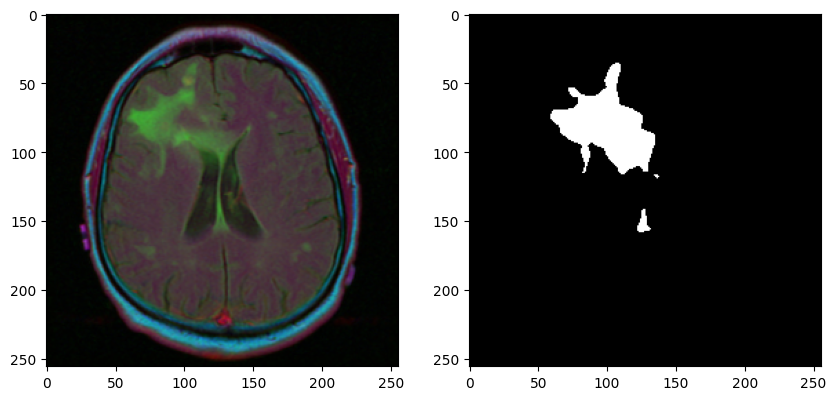

In [8]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/deformable_unet.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()

## Training and Evaluating DeepLabv4

In [9]:
model = DeepLabv4(3, 1)
train_and_evaluate(model, 'deeplabv4', augment=True, oversample=False)

--------- Epoch 1 ---------
Current learning rate: 0.00100


49it [00:14,  3.44it/s]


[Train]  Loss: 0.9746
[Test]  Loss: 0.9481 mIoU: 0.1051 Precision: 0.1051 Recall: 0.9989 F1: 0.1286
--------- Epoch 2 ---------
Current learning rate: 0.00100


49it [00:13,  3.62it/s]


[Train]  Loss: 0.8915
[Test]  Loss: 0.8267 mIoU: 0.6640 Precision: 0.7711 Recall: 0.8710 F1: 0.7042
--------- Epoch 3 ---------
Current learning rate: 0.00099


49it [00:13,  3.63it/s]


[Train]  Loss: 0.7295
[Test]  Loss: 0.6942 mIoU: 0.7178 Precision: 0.8551 Recall: 0.8447 F1: 0.7520
--------- Epoch 4 ---------
Current learning rate: 0.00098


49it [00:13,  3.57it/s]


[Train]  Loss: 0.4806
[Test]  Loss: 0.4951 mIoU: 0.7557 Precision: 0.8775 Recall: 0.8632 F1: 0.7918
--------- Epoch 5 ---------
Current learning rate: 0.00096


49it [00:13,  3.55it/s]


[Train]  Loss: 0.3496
[Test]  Loss: 0.4391 mIoU: 0.7533 Precision: 0.9289 Recall: 0.8147 F1: 0.7804
--------- Epoch 6 ---------
Current learning rate: 0.00093


49it [00:13,  3.58it/s]


[Train]  Loss: 0.3253
[Test]  Loss: 0.5662 mIoU: 0.7299 Precision: 0.9516 Recall: 0.7683 F1: 0.7604
--------- Epoch 7 ---------
Current learning rate: 0.00090


49it [00:13,  3.56it/s]


[Train]  Loss: 0.3065
[Test]  Loss: 0.3998 mIoU: 0.7924 Precision: 0.9217 Recall: 0.8620 F1: 0.8232
--------- Epoch 8 ---------
Current learning rate: 0.00087


49it [00:13,  3.55it/s]


[Train]  Loss: 0.2821
[Test]  Loss: 0.3673 mIoU: 0.7983 Precision: 0.9301 Recall: 0.8568 F1: 0.8278
--------- Epoch 9 ---------
Current learning rate: 0.00083


49it [00:13,  3.56it/s]


[Train]  Loss: 0.2671
[Test]  Loss: 0.4634 mIoU: 0.7761 Precision: 0.9477 Recall: 0.8197 F1: 0.8037
--------- Epoch 10 ---------
Current learning rate: 0.00079


49it [00:13,  3.54it/s]


[Train]  Loss: 0.2311
[Test]  Loss: 0.3841 mIoU: 0.7196 Precision: 0.8107 Recall: 0.8985 F1: 0.7562
--------- Epoch 11 ---------
Current learning rate: 0.00075


49it [00:13,  3.57it/s]


[Train]  Loss: 0.2325
[Test]  Loss: 0.4042 mIoU: 0.7461 Precision: 0.8482 Recall: 0.8885 F1: 0.7797
--------- Epoch 12 ---------
Current learning rate: 0.00070


49it [00:13,  3.56it/s]


[Train]  Loss: 0.2278
[Test]  Loss: 0.3373 mIoU: 0.7664 Precision: 0.8603 Recall: 0.8952 F1: 0.8039
--------- Epoch 13 ---------
Current learning rate: 0.00065


49it [00:13,  3.61it/s]


[Train]  Loss: 0.2205
[Test]  Loss: 0.2845 mIoU: 0.8111 Precision: 0.9339 Recall: 0.8649 F1: 0.8445
--------- Epoch 14 ---------
Current learning rate: 0.00060


49it [00:13,  3.59it/s]


[Train]  Loss: 0.2049
[Test]  Loss: 0.3024 mIoU: 0.8165 Precision: 0.9383 Recall: 0.8675 F1: 0.8484
--------- Epoch 15 ---------
Current learning rate: 0.00055


49it [00:14,  3.50it/s]


[Train]  Loss: 0.2020
[Test]  Loss: 0.4100 mIoU: 0.7710 Precision: 0.9605 Recall: 0.8022 F1: 0.7978
--------- Epoch 16 ---------
Current learning rate: 0.00050


49it [00:13,  3.51it/s]


[Train]  Loss: 0.2000
[Test]  Loss: 0.3462 mIoU: 0.8096 Precision: 0.9431 Recall: 0.8573 F1: 0.8407
--------- Epoch 17 ---------
Current learning rate: 0.00045


49it [00:13,  3.62it/s]


[Train]  Loss: 0.1921
[Test]  Loss: 0.3129 mIoU: 0.8047 Precision: 0.9225 Recall: 0.8707 F1: 0.8378
--------- Epoch 18 ---------
Current learning rate: 0.00040


49it [00:14,  3.49it/s]


[Train]  Loss: 0.1801
[Test]  Loss: 0.3185 mIoU: 0.8136 Precision: 0.9182 Recall: 0.8855 F1: 0.8468
--------- Epoch 19 ---------
Current learning rate: 0.00035


49it [00:13,  3.63it/s]


[Train]  Loss: 0.1849
[Test]  Loss: 0.2802 mIoU: 0.7794 Precision: 0.8481 Recall: 0.9156 F1: 0.8190
--------- Epoch 20 ---------
Current learning rate: 0.00030


49it [00:13,  3.59it/s]


[Train]  Loss: 0.1637
[Test]  Loss: 0.2342 mIoU: 0.8167 Precision: 0.9020 Recall: 0.9022 F1: 0.8540
--------- Epoch 21 ---------
Current learning rate: 0.00025


49it [00:13,  3.53it/s]


[Train]  Loss: 0.1600
[Test]  Loss: 0.2511 mIoU: 0.8306 Precision: 0.9214 Recall: 0.8995 F1: 0.8641
--------- Epoch 22 ---------
Current learning rate: 0.00021


49it [00:14,  3.50it/s]


[Train]  Loss: 0.1565
[Test]  Loss: 0.2378 mIoU: 0.8341 Precision: 0.9301 Recall: 0.8953 F1: 0.8690
--------- Epoch 23 ---------
Current learning rate: 0.00017


49it [00:13,  3.50it/s]


[Train]  Loss: 0.1520
[Test]  Loss: 0.2309 mIoU: 0.8325 Precision: 0.9249 Recall: 0.8976 F1: 0.8679
--------- Epoch 24 ---------
Current learning rate: 0.00013


49it [00:14,  3.45it/s]


[Train]  Loss: 0.1540
[Test]  Loss: 0.2232 mIoU: 0.8279 Precision: 0.8978 Recall: 0.9183 F1: 0.8633
--------- Epoch 25 ---------
Current learning rate: 0.00010


49it [00:13,  3.60it/s]


[Train]  Loss: 0.1531
[Test]  Loss: 0.2185 mIoU: 0.8398 Precision: 0.9273 Recall: 0.9028 F1: 0.8751
--------- Epoch 26 ---------
Current learning rate: 0.00007


49it [00:13,  3.63it/s]


[Train]  Loss: 0.1392
[Test]  Loss: 0.2132 mIoU: 0.8418 Precision: 0.9242 Recall: 0.9077 F1: 0.8761
--------- Epoch 27 ---------
Current learning rate: 0.00004


49it [00:13,  3.61it/s]


[Train]  Loss: 0.1418
[Test]  Loss: 0.2143 mIoU: 0.8412 Precision: 0.9241 Recall: 0.9070 F1: 0.8764
--------- Epoch 28 ---------
Current learning rate: 0.00002


49it [00:13,  3.64it/s]


[Train]  Loss: 0.1498
[Test]  Loss: 0.2123 mIoU: 0.8410 Precision: 0.9269 Recall: 0.9040 F1: 0.8753
--------- Epoch 29 ---------
Current learning rate: 0.00001


49it [00:13,  3.65it/s]


[Train]  Loss: 0.1337
[Test]  Loss: 0.2107 mIoU: 0.8409 Precision: 0.9226 Recall: 0.9082 F1: 0.8753
--------- Epoch 30 ---------
Current learning rate: 0.00000


49it [00:13,  3.65it/s]


[Train]  Loss: 0.1402
[Test]  Loss: 0.2102 mIoU: 0.8362 Precision: 0.9152 Recall: 0.9110 F1: 0.8711


## Visual validation of the Model Prediction

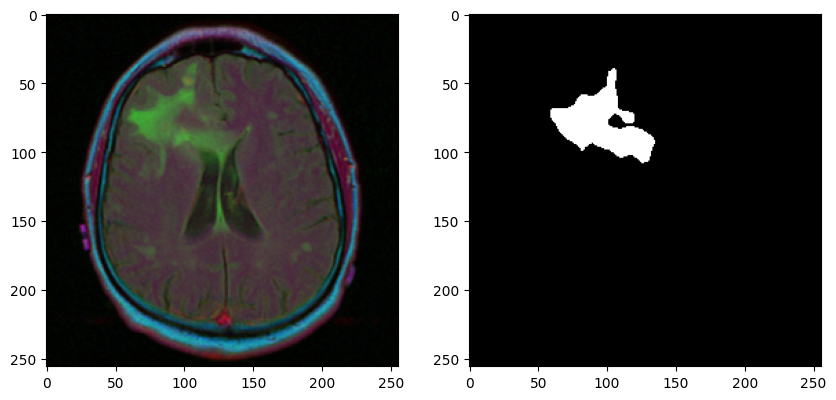

In [10]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/deeplabv4.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()